In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import kagglehub
import os


/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Downloading the Financial Dataset from kaggle

# Download latest version
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print("Path to dataset files:", (path))

Path to dataset files: /home/harry/.cache/kagglehub/datasets/sbhatti/financial-sentiment-analysis/versions/4


In [4]:
df = pd.read_csv(f'{path}/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.dropna()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [4]:
df.drop_duplicates()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [ ]:
df.shape

(5842, 2)

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3130
positive,1852
negative,860


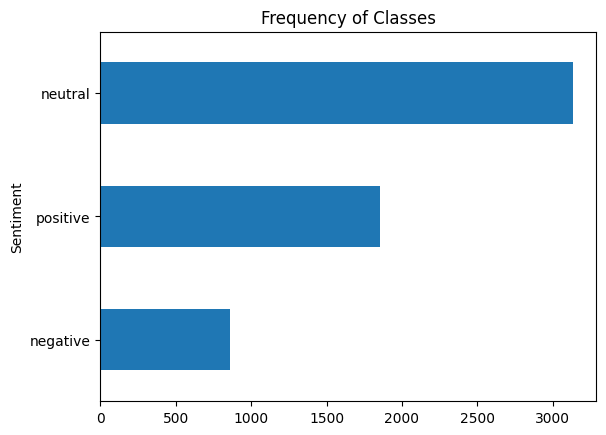

In [ ]:
# looking at the class distribution

import matplotlib.pyplot as plt

df['Sentiment'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

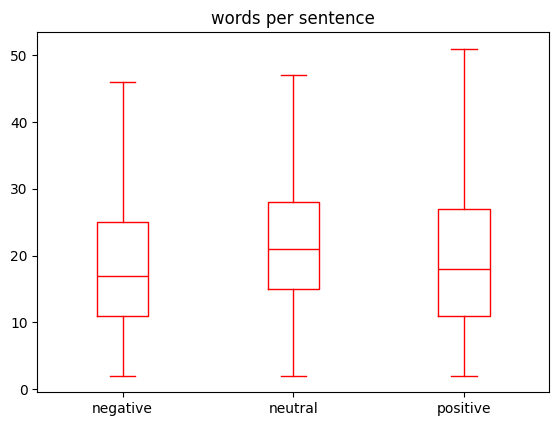

In [ ]:
df['words per sentence'] = df['Sentence'].str.split().apply(len)
df.boxplot('words per sentence',by ='Sentiment',grid=False,showfliers=False,color='red')

plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
df['label'] = df['Sentiment'].apply(lambda x: 0 if x == 'neutral' else 1 if x == 'positive' else 2 if x=='negative' else None)
df['label']

,label
0,1
1,2
2,1
3,0
4,0
...,...
5837,2
5838,0
5839,0
5840,0


In [ ]:
import spacy
import re

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Custom contraction mapping
CONTRACTION_MAP = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'ve": " have",
    "'m": " am",
    "it's": "it is",
    "that's": "that is"
}

def fix_contractions(text):
    for contraction, expansion in CONTRACTION_MAP.items():
        text = text.replace(contraction, expansion)
    return text

def preprocess_financial_text(text, keep_negs=True, keep_numbers=True, keep_currency=True):
    """
    Preprocess financial text with special handling for:
    - Currency symbols and amounts ($, Rs, NPR)
    - Nepali news content (basic handling)
    - Financial terminology preservation
    """

    # Expand contractions
    text = fix_contractions(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Special handling for financial amounts before tokenization
    if keep_currency:
        # Normalize currency representations
        text = re.sub(r'\$(\d+\.?\d*)', r'dollar_\1', text)  # $100 → dollar_100
        text = re.sub(r'(\d+\.?\d*)\s?dollars?', r'dollar_\1', text, flags=re.IGNORECASE)
        text = re.sub(r'Rs\.?\s?(\d+\.?\d*)', r'rupee_\1', text)  # Rs 100 → rupee_100
        text = re.sub(r'NPR\s?(\d+\.?\d*)', r'npr_\1', text)  # NPR 100 → npr_100

    # Process with spaCy
    doc = nlp(text)

    processed_tokens = []
    for token in doc:
        if token.is_space:
            continue

        # Keep currency terms as single tokens
        if keep_currency and token.text.lower() in ['$', 'rs', 'npr', 'dollar', 'rupee']:
            processed_tokens.append(token.text.lower())
            continue

        # Handle punctuation - keep only certain financial-relevant punctuation
        if token.is_punct and token.text not in ['%', '.']:  # Keep percentage and decimal points
            continue

        # Handle numbers based on parameter
        if not keep_numbers and token.like_num:
            continue

        # Handle stop words with negation preservation
        if token.is_stop and not (keep_negs and token.lower_ in ["not", "no", "never", "nor"]):
            continue

        # Lemmatization
        lemma = token.lemma_.lower().strip()

        # Special handling for financial terms
        if lemma in ['stock', 'share', 'price', 'market']:  # Don't lemmatize these
            lemma = token.text.lower()

        if lemma:
            processed_tokens.append(lemma)

    return " ".join(processed_tokens)


df['cleaned_sentences'] = df['Sentence'].apply(preprocess_financial_text)

In [ ]:
df.head()

,Sentence,Sentiment,words per sentence,label,cleaned_sentences
0,The GeoSolutions technology will leverage Bene...,positive,32,1,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11,2,$ esi low dollar_1.50 dollar_2.50 bk real poss...
2,"For the last quarter of 2010 , Componenta 's n...",positive,39,1,quarter 2010 componenta net sale double eur131...
3,According to the Finnish-Russian Chamber of Co...,neutral,20,0,accord finnish russian chamber commerce major ...
4,The Swedish buyout firm has sold its remaining...,neutral,23,0,swedish buyout firm sell remain 22.4 percent s...


# Using Pretrained Model , Finetuning it for our case

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check if GPU is available and configure TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Use the first available GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Invalid device or cannot modify logical devices once initialized.
        print(e)
else:
    print("No GPU available, using CPU.")


token = ""

tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert",token=token)
model = TFBertForSequenceClassification.from_pretrained("ProsusAI/finbert",token=token)

# Load your CSV
texts, labels = df['Sentence'].tolist(), df['label'].tolist()

def encode(text, label):
    text = tf.compat.as_str(text.numpy())  # bytes → str wrapper
    tokens = tokenizer(
        text, max_length=128, truncation=True, padding="max_length"
    )
    return (
        tf.convert_to_tensor(tokens["input_ids"], dtype=tf.int32),
        tf.convert_to_tensor(tokens["attention_mask"], dtype=tf.int32),
        label,
    )


def tf_encode(text, label):
    input_ids, attention_mask, lbl = tf.py_function(
        func=encode,
        inp=[text, label],
        Tout=[tf.int32, tf.int32, tf.int32]
    )
    label = tf.cast(lbl, tf.int64)
    input_ids.set_shape([None])
    attention_mask.set_shape([None])
    label.set_shape([])
    return {"input_ids": input_ids, "attention_mask": attention_mask}, label



# Create tf.data.Dataset
ds = tf.data.Dataset.from_tensor_slices((texts, labels))
ds = ds.map(tf_encode).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Split into train/val or use tfds
ds_train = ds.take(80)  # example split
ds_valid = ds.skip(80)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"],
)
model.fit(ds_train, validation_data=ds_valid, epochs=3)

# Save
model.save_pretrained("finbert_tf2")
tokenizer.save_pretrained("finbert_tf2")

1 Physical GPUs, 1 Logical GPU


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
80/80 [==============================] - 149s 1s/step - loss: 0.5538 - accuracy: 0.7801 - val_loss: 0.4033 - val_accuracy: 0.8282
Epoch 2/5
80/80 [==============================] - 92s 1s/step - loss: 0.3456 - accuracy: 0.8406 - val_loss: 0.3717 - val_accuracy: 0.8257
Epoch 3/5
80/80 [==============================] - 93s 1s/step - loss: 0.2575 - accuracy: 0.8793 - val_loss: 0.3998 - val_accuracy: 0.8169
Epoch 4/5
80/80 [==============================] - 93s 1s/step - loss: 0.2191 - accuracy: 0.8957 - val_loss: 0.3564 - val_accuracy: 0.8294
Epoch 5/5
80/80 [==============================] - 97s 1s/step - loss: 0.1849 - accuracy: 0.9012 - val_loss: 0.3931 - val_accuracy: 0.8282


('finbert_tf2/tokenizer_config.json',
 'finbert_tf2/special_tokens_map.json',
 'finbert_tf2/vocab.txt',
 'finbert_tf2/added_tokens.json')

In [ ]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import pickle
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(model, file)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
